## Scatterplot smoothing by LOWESS

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import ipywidgets as widgets
%matplotlib notebook

### Import data

<IPython.core.display.Javascript object>


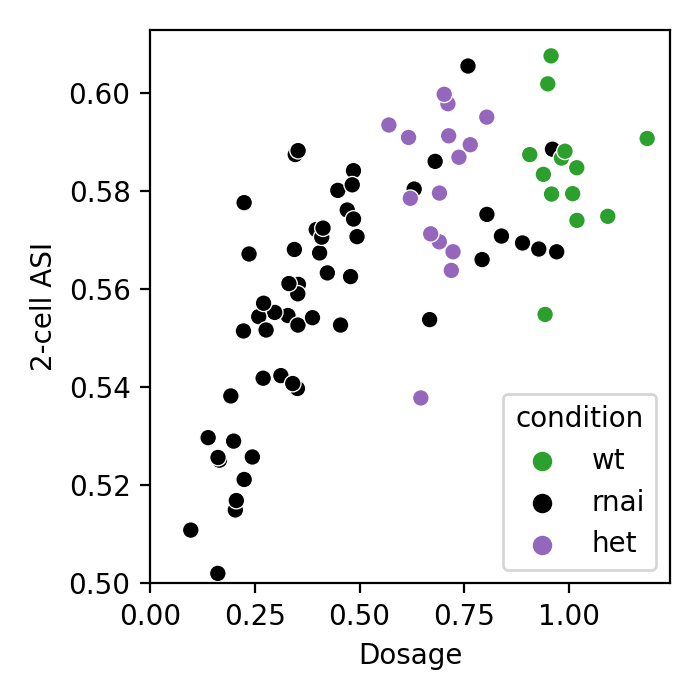

In [2]:
# Import data
df = pd.read_csv('../example datasets/dosage_vs_2cellASI_par6.csv')

# Exclude entries with missing 2-cell ASI measurements
df = df[~df['2-cell asi'].isnull()]

# Plot
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='dosage', y='2-cell asi', hue='condition', ax=ax, palette=['tab:green', 'k', 'tab:purple'])
ax.set_xlabel('Dosage')
ax.set_ylabel('2-cell ASI')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

In [3]:
# Convert data to np arrays
xdata = df['dosage'].to_numpy()
ydata = df['2-cell asi'].to_numpy()

### LOWESS fit

In [4]:
help(lowess)

Help on function lowess in module statsmodels.nonparametric.smoothers_lowess:

lowess(endog, exog, frac=0.6666666666666666, it=3, delta=0.0, xvals=None, is_sorted=False, missing='drop', return_sorted=True)
    LOWESS (Locally Weighted Scatterplot Smoothing)
    
    A lowess function that outs smoothed estimates of endog
    at the given exog values from points (exog, endog)
    
    Parameters
    ----------
    endog : 1-D numpy array
        The y-values of the observed points
    exog : 1-D numpy array
        The x-values of the observed points
    frac : float
        Between 0 and 1. The fraction of the data used
        when estimating each y-value.
    it : int
        The number of residual-based reweightings
        to perform.
    delta : float
        Distance within which to use linear-interpolation
        instead of weighted regression.
    xvals: 1-D numpy array
        Values of the exogenous variable at which to evaluate the regression.
        If supplied, cannot us

<IPython.core.display.Javascript object>


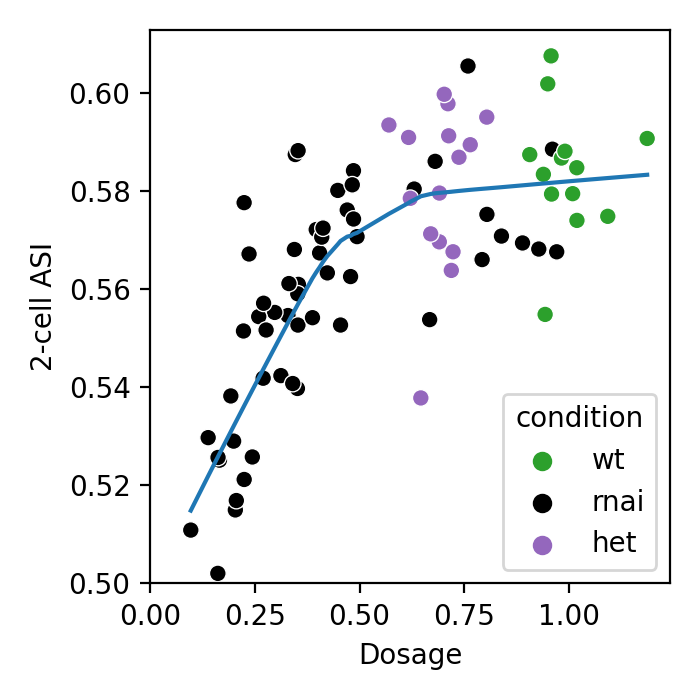

interactive(children=(FloatSlider(value=0.66, description='frac', max=1.0, step=0.01), IntSlider(value=3, desc…

In [5]:
fig, ax = plt.subplots()
@widgets.interact(frac=(0, 1, 0.01), it=(0, 5, 1), delta=(0, 1, 0.1))
def update(frac=0.66, it=3, delta=0.0): 
    ax.clear()
    sns.scatterplot(data=df, x='dosage', y='2-cell asi', hue='condition', ax=ax, 
                    palette=['tab:green', 'k', 'tab:purple'])
    res = lowess(ydata, xdata, frac=frac, it=it, delta=delta)
    ax.plot(res[:, 0], res[:, 1])
    ax.set_xlabel('Dosage')
    ax.set_ylabel('2-cell ASI')
    ax.set_ylim(bottom=0.5)
    ax.set_xlim(left=0)
    
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

### Bootstrapping

<IPython.core.display.Javascript object>


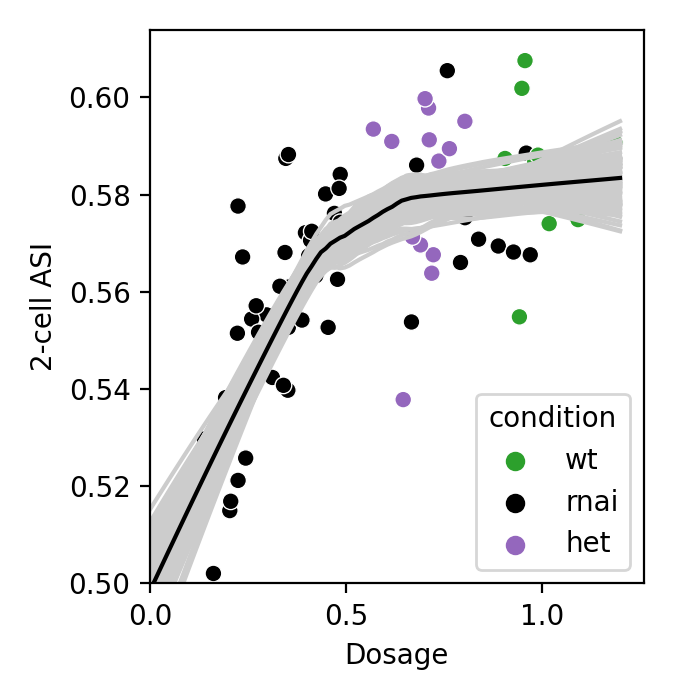

In [6]:
# Plot data
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='dosage', y='2-cell asi', hue='condition', ax=ax, palette=['tab:green', 'k', 'tab:purple'])

# LOWESS on full dataset
res = lowess(ydata, xdata, xvals=np.linspace(0, 1.2, 100))
ax.plot(np.linspace(0, 1.2, 100), res, c='k', zorder=999)
    
# Fitting on 100 bootstrap samples
for i in range(100):  
    inds = np.random.choice(range(len(ydata)), len(ydata))
    res = lowess(ydata[inds], xdata[inds], xvals=np.linspace(0, 1.2, 100))
    ax.plot(np.linspace(0, 1.2, 100), res, c='0.8')
    
# Finalise figure
ax.set_xlabel('Dosage')
ax.set_ylabel('2-cell ASI')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

### Confidence interval

In [7]:
interval = 95 ### <- confidence interval to calculate
n = 1000 ### <- number of bootstrap samples

# Run bootstrapping
xvals = np.linspace(0, 1.2, 100)
res = []
res_whole = lowess(ydata, xdata, xvals=xvals)
for i in range(n):  
    inds = np.random.choice(range(len(ydata)), len(ydata))
    res.append(lowess(ydata[inds], xdata[inds], xvals=xvals))
res = np.array(res)

# Calculate confidence intervals
res_lower = np.percentile(res, (100 - interval) / 2, axis=0)
res_upper = np.percentile(res, 50 + (interval / 2), axis=0)

<IPython.core.display.Javascript object>


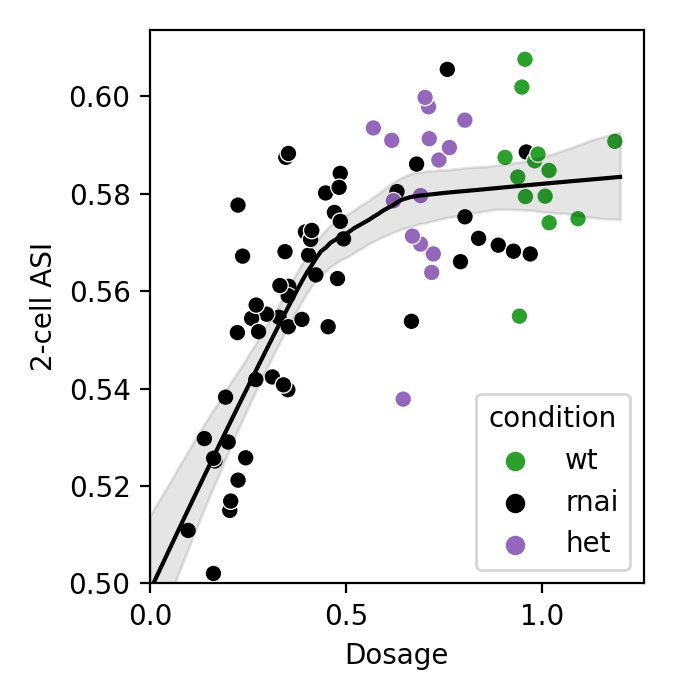

In [8]:
# Plot
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='dosage', y='2-cell asi', hue='condition', ax=ax, 
               palette=['tab:green', 'k', 'tab:purple'])
ax.plot(xvals, res_whole, c='k')
ax.fill_between(xvals, res_lower, res_upper, alpha=0.1, color='k')
ax.set_xlabel('Dosage')
ax.set_ylabel('2-cell ASI')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()